In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
moveVelocity = 0.75 / 60
TLik = 1738.0
TSol = 1679.0
TEnv = 303
TEnv4 = TEnv ** 4

L = 272000.0
cLik = 710.0
X = 0.7

totalLength = (0.4 + 0.4 + 0.47 + 0.95 + 1.51 + 18.97)

Temps = [
    273.0, 373.0, 473.0, 573.0, 673.0, 773.0, 873.0, 973.0, 1073.0, 1173.0, 
    1273.0, 1373.0, 1473.0, 1679.0, 1682.0, 1800.0
]
Lambds = [
    52.56057, 51.35258, 49.16971, 46.22939, 42.74907, 38.94618, 35.03819,
    31.24254, 24.06517, 25.37233, 26.95363, 28.32515, 29.40302, 31.62343,
    28.0, 28.0
]
Ros = [
    7885.884, 7845.138, 7804.392, 7763.646, 7722.9, 7682.901, 7647.512, 7621.141,
    7631.934, 7572.359, 7512.151, 7453.459, 7398.322, 7190.562, 7000.0, 7000.0,
]
def Lambda(T):
    return np.interp(T, Temps, Lambds)

def Ro(T):
    return np.interp(T, Temps, Ros)

Ti = [ 1000.0, 1033.0, 923.0, 1033.0 ]
dTi = [ 70.0, 350.0, 1100.0, 170.0 ]
MLiT = np.array([
    44076.0 - (85622.0 * X - 50357.0) * X,
    5163.2 - (74009.0 * X - 70232.0) * X,
    2622.3 - (92590.0 * X - 80523.0) * X,
    14775 + (154544.0 * X - 142489.0) * X
]) * 4.5141 / dTi

def cSol(T):
    return 469.0 + 0.16 * (T - 323.0) + sum(MLiT[i] * exp(-16.0 * ((Ti[i] - T) / dTi[i]) ** 2) for i in [0, 1, 2, 3])

def ksiFunc(T):
    return (1.3191416161402142e9 - 1.512210568295802e6 * T + 444.52 * T*T) / ((1.8691015431878914e6 - 2843.51 * T + T*T)**2)

def CEf(T):
    if T >= TLik:
        return cLik
    elif T > TSol:
        return cSol(T) + L * ksiFunc(T)
    else:
        return cSol(T)

def Alpha(t):
    x = t * moveVelocity
    if x <= 0.4:
        return 2100.0
    elif x <= 0.4 + 0.4:
        return 60.0
    elif x <= 0.4 + 0.4 + 0.47:
        return 850.0
    elif x <= 0.4 + 0.4 + 0.47 + 0.95:
        return 120.0
    elif x <= 0.4 + 0.4 + 0.47 + 0.95 + 1.51:
        return 40.0
    else:
        return 25.0

def Sigma(t):
    x = t * moveVelocity
    if x <= 0.4 + 0.4 + 0.47 + 0.95 + 1.51:
        return 0.0
    else:
        return 3.2e-8

In [500]:
def fillFactors(rw, brw, aF, bF, cF, fF, t, dT, hX):
    width = len(rw)
    
    lm0, lmh = Lambda(brw[0]), Lambda(brw[1])
    aF[0] = 0
    cF[0] = dT * (lm0 + lmh) + (hX ** 2) * Ro(brw[0]) * CEf(brw[0])
    bF[0] = -dT * (lm0 + lmh)
    fF[0] = (hX ** 2) * Ro(brw[0]) * CEf(brw[0]) * rw[0]
    
    TPrev = brw[-1]
    TPrev4 = TPrev ** 4
    lmXX, lmXXm1 = Lambda(brw[-1]), Lambda(brw[-2])
    aF[-1] = -dT * (lmXXm1 + lmXX)
    cF[-1] = dT * (lmXXm1 + lmXX) + (hX ** 2) * Ro(brw[-1]) * CEf(brw[-1]) + 2 * hX * dT * Alpha(t)
    bF[-1] = 0
    fF[-1] = (hX ** 2) * Ro(brw[-1]) * CEf(brw[-1]) * rw[-1] - 2 * hX * dT * Sigma(t) * (TPrev4 - TEnv4) + 2 * hX * dT * Alpha(t) * TEnv
    
    lmXm1, lmX, lmXp1 = lm0, lmh, 0
    for index in xrange(1, width - 1):
        lmXp1 = Lambda(brw[index + 1])
        mhh2rocdT = - 2 * (hX ** 2) * Ro(brw[index]) * CEf(brw[index]) / dT
        aF[index] = lmX + lmXm1
        bF[index] = lmXp1 + lmX
        cF[index] = -(lmXp1 + 2 * lmX + lmXm1) + mhh2rocdT
        fF[index] = mhh2rocdT * rw[index]
        lmXm1, lmX = lmX, lmXp1

def firstPass(aF, bF, cF, fF):
    for i in xrange(1, len(aF)):
        m = aF[i] / cF[i - 1]
        cF[i] -= m * bF[i - 1]
        fF[i] -= m * fF[i - 1]
    
def secondPass(aF, bF, cF, fF, y):
    newValue, maxDelta = 0, 0
    newValue = fF[-1] / cF[-1]
    maxDelta = abs(newValue - y[-1])
    y[-1] = newValue
    for i in xrange(len(aF) - 2, -1, -1):
        newValue = (fF[i] - bF[i] * y[i + 1]) / cF[i]
        newDelta = abs(newValue - y[i])
        maxDelta = max(maxDelta, newDelta)
        y[i] = newValue
    return maxDelta

def solveRow(row, t, dT = 0.09, dH = 0.000015, epsilon = 0.01):
    curRow = row.copy()
    its, delta = 0, 0.0
    [a, b, c, f] = [np.zeros(len(row), dtype='float64') for ppp in xrange(4)]
    for k in xrange(50):
    #while True:
        fillFactors(row, curRow, a, b, c, f, t, dT, dH)
        firstPass(a, b, c, f)
        delta = secondPass(a, b, c, f, curRow)
        its += 1
        if delta < epsilon:
            break
    #print delta, its
    return curRow, its

import multiprocessing
pool = multiprocessing.Pool()

def passMtr(mtr, t, dT = 0.09, dH = 0.00015, epsilon = 0.01):
    nmtr = []
    itss = []
    ri = pool.map(lambda row: solveRow(row, t, dT, dH, epsilon), mtr)
    for row in mtr:
        rw, its = solveRow(row, t, dT, dH, epsilon)
        nmtr += [rw]
        itss += [its]
    return np.array(nmtr), np.array(itss)



def solveMtr(mtr, t, dT = 0.09, dH = 0.00015, epsilon = 0.01):
    mtr, itss1 = passMtr(mtr, t, dT, dH, epsilon)
    mtr, itss2 = passMtr(mtr.T, t, dT, dH, epsilon)
    return mtr, np.array([itss1 for i in xrange(len(itss2))]).T + np.array([itss2 for i in xrange(len(itss1))])

In [ ]:
row = np.ones(10000, dtype='float64') * 1768.0
dT = 0.09
times = np.arange(1000) * dT
temps = []
itss = []
for t in times:
    row, its = solveRow(row, t, dT)
    temps += [row[-1]]
    itss += [its]
    
plot(times, temps)
plt.show()
plot(times, itss)
plt.show()

In [298]:
def plot2d(H, limmin = 0, limmax = 1800):
    fig = plt.figure(figsize=(6, 3.2))
    
    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    shp = H.shape
    print shp
    H.reshape(shp[0] * shp[1])
    H = H.astype('int')
    H.reshape(shp)
    imshow(H)
    plt.clim(limmin, limmax)
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()

In [499]:
N = 50
mtr = (np.ones(N * N) * 1768.0).reshape([N, N])

In [ ]:
def foo(row):
    return solveRow(row, 0)
ri = pool.map(foo, list(mtr))

(50, 50)


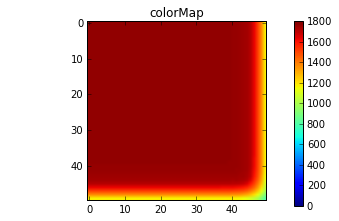

(50, 50)


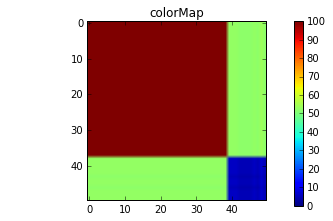

In [498]:
mtr, itss = solveMtr(mtr, 0, 0.9, 0.0030, 1)
plot2d(mtr)
plot2d(itss, 0, 100)

In [293]:
itss

array([   9,    9,    9,    9,    9,    9,    9,    9,    9,    9,    9,
          9,    9,    9,    9,    9,    9,    9,    9,    9,    9,    9,
          9,    9,    9,    9, 2500,    9,    9,    9,    9,   12,   12,
          9,    4,   12,    9,   12,    9,   12,    9,    6,    6,    6,
          6,    6,    4,    4,    4,    4])

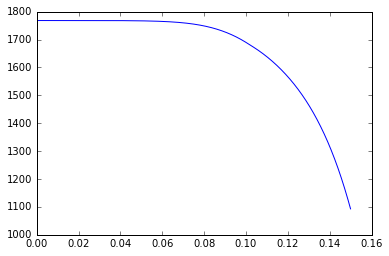

In [56]:
plot(np.arange(len(row)) * 0.000015, row)

In [ ]:
%tim

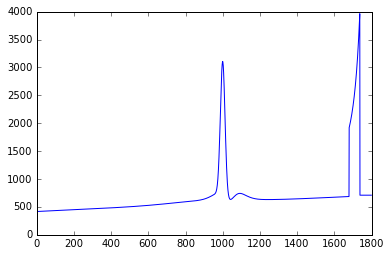

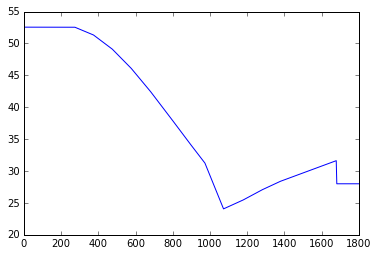

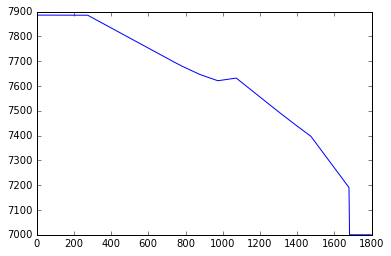

In [21]:
x = np.arange(1800)
yCEf = map(CEf, x)
plot(x, yCEf)
plt.show()

yLambda = map(Lambda, x)
plot(x, yLambda)
plt.show()

yRo = map(Ro, x)
plot(x, yRo)
plt.show()